<a href="https://colab.research.google.com/github/Debajyoti2004/GANs-Paper-implementations/blob/main/WGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import torch
import torch.nn as nn

In [42]:
class Critic(nn.Module):
  def __init__(self,channels_img,features_d):
    super(Critic,self).__init__()
    # Input: N * channels_img * 64 * 64
    self.disc = nn.Sequential(
        nn.Conv2d(
            channels_img,
            features_d,
            kernel_size=4,
            stride=2,
            padding=1,
        ), # 32*32
        nn.LeakyReLU(0.2),
        self._block(features_d,features_d*2,4,2,1),#16*16
        self._block(features_d*2,features_d*4,4,2,1),#8*8
        self._block(features_d*4,features_d*8,4,2,1),#4*4
        nn.Conv2d(
            features_d*8,
            1,
            kernel_size=4,
            stride=2,
            padding=0
        )
    )

  def _block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
        )

  def forward(self,x):
      return self.disc(x)


In [43]:
class Generator(nn.Module):
  def __init__(self,z_dim,channels_img,features_g):
    super(Generator,self).__init__()
    self.gen = nn.Sequential(
        self._block(z_dim,features_g*16,4,1,0), # N x f_g*16 x 4 x 4
        self._block(features_g*16,features_g*8,4,2,1), # 8x8
        self._block(features_g*8,features_g*4,4,2,1), # 16x16
        self._block(features_g*4,features_g*2,4,2,1),
        nn.ConvTranspose2d(
            features_g*2,
            channels_img,
            kernel_size=4,
            stride=2,
            padding=1,
        ),
        nn.Tanh(), #[-1,1] 64*64
    )


  def _block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self,x):
    return self.gen(x)



In [44]:
 def initialize_weights(model):
    for m in model.modules():
      if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data,0.0,0.02)

In [45]:
def test():
  N,in_channels,H,W = 8,3,64,64
  z_dim = 100
  x = torch.randn((N,in_channels,H,W))
  disc = Critic(in_channels,8)
  initialize_weights(disc)
  assert disc(x).shape == (N,1,1,1)
  print(f"output shape from disc:{disc(x).shape}")
  gen = Generator(z_dim,in_channels,8)
  initialize_weights(gen)
  z = torch.randn((N,z_dim,1,1))
  assert gen(z).shape == (N,in_channels,H,W)
  print(f"output shape from gen:{gen(z).shape}") # Changed x to z
  print("Success")

In [46]:
test()

output shape from disc:torch.Size([8, 1, 1, 1])
output shape from gen:torch.Size([8, 3, 64, 64])
Success


In [47]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATION = 5
WEIGHT_CLIP = 0.01

In [49]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)


In [51]:
from torchvision.datasets import CIFAR10

dataset = CIFAR10(root='./celeba_img', train=True, download=True, transform=transforms)

100%|██████████| 170M/170M [00:04<00:00, 35.9MB/s]


In [52]:
loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)
images, labels = next(iter(loader))
print(images.shape)

torch.Size([64, 3, 64, 64])


In [53]:
import torch.optim as optim


In [54]:

gen = Generator(Z_DIM,CHANNELS_IMG,FEATURES_GEN).to(device)
critic = Critic(CHANNELS_IMG,FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(critic)

opt_gen = optim.RMSprop(gen.parameters(),lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(),lr=LEARNING_RATE)

fixed_noise = torch.randn(32,Z_DIM,1,1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [55]:
import matplotlib.pyplot as plt
import torchvision

def plot_images(real, fake, num_images=8):
    """
    Function to plot real and fake images side by side.
    Args:
    - real: real image batch (tensor)
    - fake: fake image batch (tensor)
    - num_images: number of images to display per batch (default 8)
    """
    # Take first `num_images` from the batch for visualization
    real_batch = real[:num_images]
    fake_batch = fake[:num_images]

    # Normalize images to [0, 1]
    real_batch = (real_batch + 1) / 2
    fake_batch = (fake_batch + 1) / 2

    # Create grids of images
    real_grid = torchvision.utils.make_grid(real_batch, nrow=num_images)
    fake_grid = torchvision.utils.make_grid(fake_batch, nrow=num_images)

    # Convert to numpy arrays for display
    real_np = real_grid.permute(1, 2, 0).cpu().numpy()
    fake_np = fake_grid.permute(1, 2, 0).cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(real_np)
    axes[0].set_title("Real Images")
    axes[0].axis("off")

    axes[1].imshow(fake_np)
    axes[1].set_title("Fake Images")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


Epoch [0/5] Batch 0/782 Loss D: -0.0517, Loss G: 0.0216


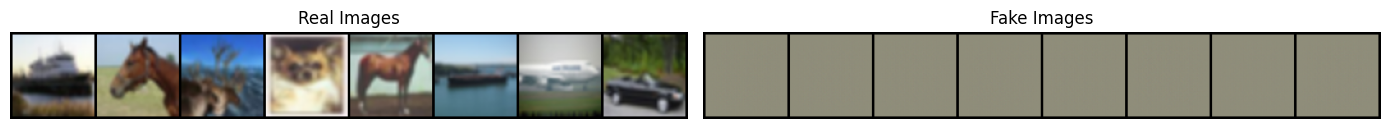

Epoch [0/5] Batch 100/782 Loss D: -1.5361, Loss G: 0.7195
Epoch [0/5] Batch 200/782 Loss D: -1.5316, Loss G: 0.7215
Epoch [0/5] Batch 300/782 Loss D: -1.5481, Loss G: 0.7248
Epoch [0/5] Batch 400/782 Loss D: -1.5485, Loss G: 0.7248
Epoch [0/5] Batch 500/782 Loss D: -1.5425, Loss G: 0.7203
Epoch [0/5] Batch 600/782 Loss D: -1.5493, Loss G: 0.7253
Epoch [0/5] Batch 700/782 Loss D: -1.5486, Loss G: 0.7255
Epoch [1/5] Batch 0/782 Loss D: -1.5503, Loss G: 0.7257


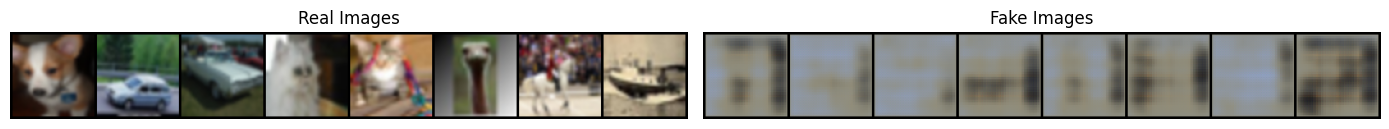

Epoch [1/5] Batch 100/782 Loss D: -1.5499, Loss G: 0.7258
Epoch [1/5] Batch 200/782 Loss D: -1.5482, Loss G: 0.7253
Epoch [1/5] Batch 300/782 Loss D: -1.5487, Loss G: 0.7253
Epoch [1/5] Batch 400/782 Loss D: -1.5499, Loss G: 0.7256
Epoch [1/5] Batch 500/782 Loss D: -1.5488, Loss G: 0.7249
Epoch [1/5] Batch 600/782 Loss D: -1.5499, Loss G: 0.7256
Epoch [1/5] Batch 700/782 Loss D: -1.5501, Loss G: 0.7256
Epoch [2/5] Batch 0/782 Loss D: -1.5470, Loss G: 0.7245


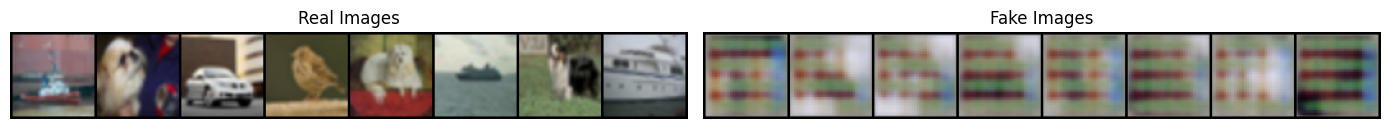

Epoch [2/5] Batch 100/782 Loss D: -1.5365, Loss G: 0.7218
Epoch [2/5] Batch 200/782 Loss D: -1.5415, Loss G: 0.7218
Epoch [2/5] Batch 300/782 Loss D: -1.5311, Loss G: 0.7166
Epoch [2/5] Batch 400/782 Loss D: -1.5080, Loss G: 0.6960
Epoch [2/5] Batch 500/782 Loss D: -1.5237, Loss G: 0.7142
Epoch [2/5] Batch 600/782 Loss D: -1.4534, Loss G: 0.6777
Epoch [2/5] Batch 700/782 Loss D: -1.4525, Loss G: 0.6826
Epoch [3/5] Batch 0/782 Loss D: -1.4403, Loss G: 0.6751


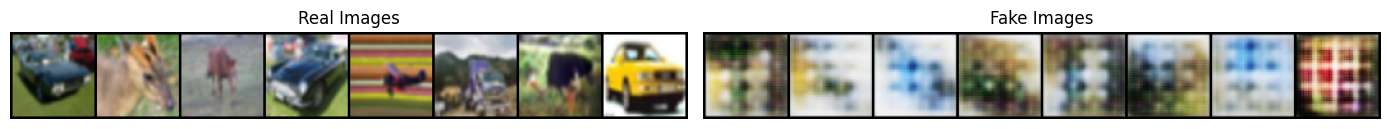

Epoch [3/5] Batch 100/782 Loss D: -1.0410, Loss G: 0.3753
Epoch [3/5] Batch 200/782 Loss D: -0.9383, Loss G: 0.6012
Epoch [3/5] Batch 300/782 Loss D: -0.9114, Loss G: 0.5784
Epoch [3/5] Batch 400/782 Loss D: -0.9842, Loss G: 0.4055
Epoch [3/5] Batch 500/782 Loss D: -1.0975, Loss G: 0.5302
Epoch [3/5] Batch 600/782 Loss D: -1.0723, Loss G: 0.5060
Epoch [3/5] Batch 700/782 Loss D: -1.0684, Loss G: 0.4719
Epoch [4/5] Batch 0/782 Loss D: -0.9922, Loss G: 0.4008


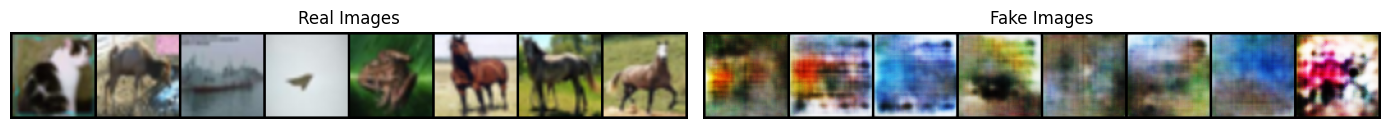

Epoch [4/5] Batch 100/782 Loss D: -1.0968, Loss G: 0.5451
Epoch [4/5] Batch 200/782 Loss D: -1.1455, Loss G: 0.5443
Epoch [4/5] Batch 300/782 Loss D: -1.0563, Loss G: 0.4503
Epoch [4/5] Batch 400/782 Loss D: -1.2072, Loss G: 0.5619
Epoch [4/5] Batch 500/782 Loss D: -0.9052, Loss G: 0.2404
Epoch [4/5] Batch 600/782 Loss D: -1.0791, Loss G: 0.5819
Epoch [4/5] Batch 700/782 Loss D: -1.1767, Loss G: 0.5358


In [56]:
step = 0
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.size(0)

        ### Train Critic ###
        for _ in range(CRITIC_ITERATION):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1, device=device)
            fake = gen(noise)

            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake.detach()).reshape(-1)

            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            opt_critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

            # Weight clipping for WGAN
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        ### Train Generator ###
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)

        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        ### Logging ###
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} "
                f"Loss D: {loss_critic:.4f}, Loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake_imgs = gen(fixed_noise)
                fake_grid = torchvision.utils.make_grid(fake_imgs, normalize=True)
                real_grid = torchvision.utils.make_grid(real[:32], normalize=True)

                writer_fake.add_image("Fake Images", fake_grid, global_step=step)
                writer_real.add_image("Real Images", real_grid, global_step=step)

            step += 1

        if batch_idx == 0:
            with torch.no_grad():
                fake_imgs = gen(fixed_noise)
            plot_images(real[:8], fake_imgs[:8])
